# PRI Project - Data Processing

Write something about the project here.

In [102]:
import pandas as pd
import re

Write something about data 1 here

In [103]:
# Read data 1 csv and drop the unnecessary data
jobs_data_1 = pd.read_csv("data/allJobs.csv")
jobs_data_1.drop(columns=["Date-Posted"],inplace=True)
jobs_data_1.dropna()
jobs_data_1.rename(columns = {'Company':'company','Job-Title':'title','Job-Type':'work-type','Salary':'salary','Location':'location','Description':'description'}, inplace = True)
jobs_data_1 = jobs_data_1[jobs_data_1.salary.notnull()]
jobs_data_1.head()

,title,company,work-type,salary,location,description
2,Central Graduate Advisor,University of Alberta,Full-time,"$47,210–$63,741 a year","Edmonton, AB",FGSR Grad Studies & Rsrch Admi\n\nCompetition ...
6,Post-doctoral Fellow,University of Alberta,Full-time,$50K a year,"Edmonton, AB",ART East Asian Studies\n\nCompetition No. -\nA...
7,Graduate Research Assistant,University of Calgary,Full-time,$20K–$25K a year,"Calgary, AB",The Adaptive Bionics Lab at the University of ...
24,Postdoctoral Fellow in Environmental Epidemiology,University of Alberta,Full-time,$50K a year,"Edmonton, AB",PH School of Public Health\n\nCompetition No. ...
78,"Advisor, Student Service Centre",University of Alberta,Full-time,"$51,055–$69,342 a year","Edmonton, AB",RO Student Service Centre\n\nCompetition No. -...


Write something about data 2 hera

In [104]:
# Read data 2 csv and drop the unnecessary data
jobs_data_2 = pd.read_csv("data/job_postings.csv")
jobs_data_2.drop(columns=["max_salary","min_salary","job_id","expiry","closed_time","applies","currency","compensation_type"	,"original_listed_time",	"remote_allowed",	"views",	"job_posting_url",	"application_url"	,"application_type","formatted_experience_level","skills_desc","listed_time",	"posting_domain",	"sponsored"	,"work_type"],inplace=True)
jobs_data_2 = jobs_data_2[jobs_data_2.pay_period.notnull()]
jobs_data_2 = jobs_data_2[jobs_data_2.med_salary.notnull()]
jobs_data_2.rename(columns = {'med_salary':'salary','formatted_work_type':'work-type'}, inplace = True)
jobs_data_2.head()

,company_id,title,description,salary,pay_period,work-type,location
18,1082195.0,Contract Bilingual Recruiter,"Location: Phoenix, AZ 85006---- IN OFFICE JOB ...",65000.00,YEARLY,Contract,"Phoenix, AZ"
96,72739246.0,After School Academic Tutor,"Sterling House Community Center, Inc. Title: A...",33.59,HOURLY,Full-time,"Stratford, CT"
99,90666319.0,oracle SCM TECHNO CLOUD FUNCTIONAL,CumminsOracle cloud SCM technical\nWe need EBS...,67.00,HOURLY,Contract,"Columbus, IN"
141,5059324.0,Estimator,EstimatorThe Procopio Companies (TPC) is a gro...,12.00,HOURLY,Full-time,"Middleton, MA"
142,5059324.0,Site Foreman,Site Crew Foreman The Procopio Companies (TPC)...,12.00,HOURLY,Full-time,"Middleton, MA"


Write something about the salary in jobs_data_1 here

In [105]:
def extract_salary_and_pay_period(salary_string):
    if 'a year' in salary_string:
        pay_period = 'YEARLY'
        match = re.search(r'\$([\d,.]+[kK]?)-?([\d,.]+[kK]?)?', salary_string)
        if match:
            low_value = match.group(1).replace(',', '').replace('k', '000').replace('K', '000')
            high_value = match.group(2).replace(',', '').replace('k', '000').replace('K', '000') if match.group(2) else low_value
            salary = (float(low_value) + float(high_value)) / 2
        else:
            match = re.search(r'\$([\d,.]+[kK]?)', salary_string)
            if match:
                salary = float(match.group(1).replace(',', '').replace('k', '000').replace('K', '000'))
            else:
                salary = None
    elif 'a month' in salary_string:
        pay_period = 'MONTHLY'
        match = re.findall(r'\$([\d,.]+[kK]?)', salary_string)
        if match:
            salary_range = [(float(m.replace(',', '').replace('k', '000').replace('K', '000'))) for m in match]
            salary = sum(salary_range) / len(salary_range)
        else:
            salary = None
    elif 'an hour' in salary_string:
        pay_period = 'HOURLY'
        match = re.search(r'\$([\d,.]+[kK]?)', salary_string)
        if match:
            salary = float(match.group(1).replace(',', '').replace('k', '000').replace('K', '000'))
        else:
            salary = None
    else:
        pay_period = 'unknown'
        salary = None
    return salary, pay_period

... apply the function

In [106]:
# Split the salary collumn into salary and pay period
jobs_data_1['salary'], jobs_data_1['pay_period'] = zip(*jobs_data_1['salary'].apply(extract_salary_and_pay_period))
jobs_data_1.head()

,title,company,work-type,salary,location,description,pay_period
2,Central Graduate Advisor,University of Alberta,Full-time,47210.0,"Edmonton, AB",FGSR Grad Studies & Rsrch Admi\n\nCompetition ...,YEARLY
6,Post-doctoral Fellow,University of Alberta,Full-time,50000.0,"Edmonton, AB",ART East Asian Studies\n\nCompetition No. -\nA...,YEARLY
7,Graduate Research Assistant,University of Calgary,Full-time,20000.0,"Calgary, AB",The Adaptive Bionics Lab at the University of ...,YEARLY
24,Postdoctoral Fellow in Environmental Epidemiology,University of Alberta,Full-time,50000.0,"Edmonton, AB",PH School of Public Health\n\nCompetition No. ...,YEARLY
78,"Advisor, Student Service Centre",University of Alberta,Full-time,51055.0,"Edmonton, AB",RO Student Service Centre\n\nCompetition No. -...,YEARLY


.. add company data

In [107]:
# Create a new dataframe for company data
company_data_1 = jobs_data_1['company'].drop_duplicates().reset_index(drop=True).reset_index()
company_data_1.columns = ['company_id', 'company']
company_data_1['company_id'] = company_data_1['company_id'] + 3700152515

jobs_data_1 = pd.merge(jobs_data_1, company_data_1, on='company', how='left')
jobs_data_1.drop(columns=["company"],inplace=True)
jobs_data_1['work-type'].replace({"Contractor": "Contract"}, inplace=True)

company_data_2 = pd.read_csv("data/companies.csv")
company_data_2.drop(columns=["description",	"company_size",	"state"	,"country"	,"city",	"zip_code",	"address",	"url"],inplace=True)
company_data_2.rename(columns = {'name':'company'}, inplace = True)

company_data = pd.concat([company_data_1,company_data_2])
company_data.head()

,company_id,company
0,3700152515,University of Alberta
1,3700152516,University of Calgary
2,3700152517,University of Newcastle
3,3700152518,Mantech International
4,3700152519,State Government of WA Department of Education


...merge dataframes

In [108]:
# Merge dataframes
jobs_data = pd.concat([jobs_data_1, jobs_data_2], ignore_index=True)
jobs_data.head()

,title,work-type,salary,location,description,pay_period,company_id
0,Central Graduate Advisor,Full-time,47210.0,"Edmonton, AB",FGSR Grad Studies & Rsrch Admi\n\nCompetition ...,YEARLY,3.700153e+09
1,Post-doctoral Fellow,Full-time,50000.0,"Edmonton, AB",ART East Asian Studies\n\nCompetition No. -\nA...,YEARLY,3.700153e+09
2,Graduate Research Assistant,Full-time,20000.0,"Calgary, AB",The Adaptive Bionics Lab at the University of ...,YEARLY,3.700153e+09
3,Postdoctoral Fellow in Environmental Epidemiology,Full-time,50000.0,"Edmonton, AB",PH School of Public Health\n\nCompetition No. ...,YEARLY,3.700153e+09
4,"Advisor, Student Service Centre",Full-time,51055.0,"Edmonton, AB",RO Student Service Centre\n\nCompetition No. -...,YEARLY,3.700153e+09


... write something about country data

In [109]:
# Read countries csv and drop the unnecessary data
countries_data = pd.read_csv("data/countries.csv")
countries_data = countries_data[["name","alpha-2","region","sub-region"]]
countries_data.head()

,name,alpha-2,region,sub-region
0,Afghanistan,AF,Asia,Southern Asia
1,Åland Islands,AX,Europe,Northern Europe
2,Albania,AL,Europe,Southern Europe
3,Algeria,DZ,Africa,Northern Africa
4,American Samoa,AS,Oceania,Polynesia


... extract city and country data

In [110]:
def extract_city_and_country(location_string, country_list):
    splited_location = location_string.split(',')
    first_word = splited_location[0]
    last_word = splited_location[-1][1:]
    country_names = country_list['name'].values
    country_alpha = country_list['alpha-2'].values

    if first_word in country_names:
        return None, first_word
    elif first_word in country_alpha:
        country = country_list[country_list['alpha-2'] == first_word]['name'].iloc[0]
        return None, country
    elif last_word in country_names:
        return first_word, last_word  
    elif last_word in country_alpha:
        country = country_list[country_list['alpha-2'] == last_word]['name'].iloc[0]
        return first_word, country  
    elif len(splited_location) > 0:
        return first_word, 'United States of America'
    return None, None

... aply function

In [111]:
# Create location table
jobs_location_data = pd.DataFrame(jobs_data['location'], columns=['location'])
jobs_location_data['city'], jobs_location_data['country'] = zip(*jobs_location_data['location'].apply(lambda x: extract_city_and_country(x, countries_data)))
jobs_location_data.drop_duplicates(inplace=True)
jobs_location_data.reset_index(drop=True, inplace=True)
jobs_location_data.insert(0, 'location_id', range(1, 1 + len(jobs_location_data)))

jobs_data = pd.merge(jobs_data, jobs_location_data[['location', 'location_id']], on='location', how='left')
jobs_data.drop(columns=['location'], inplace=True)

jobs_location_data.drop(columns=['location'], inplace=True)
jobs_data.head()

,title,work-type,salary,description,pay_period,company_id,location_id
0,Central Graduate Advisor,Full-time,47210.0,FGSR Grad Studies & Rsrch Admi\n\nCompetition ...,YEARLY,3.700153e+09,1
1,Post-doctoral Fellow,Full-time,50000.0,ART East Asian Studies\n\nCompetition No. -\nA...,YEARLY,3.700153e+09,1
2,Graduate Research Assistant,Full-time,20000.0,The Adaptive Bionics Lab at the University of ...,YEARLY,3.700153e+09,2
3,Postdoctoral Fellow in Environmental Epidemiology,Full-time,50000.0,PH School of Public Health\n\nCompetition No. ...,YEARLY,3.700153e+09,1
4,"Advisor, Student Service Centre",Full-time,51055.0,RO Student Service Centre\n\nCompetition No. -...,YEARLY,3.700153e+09,1


... graphic 8K HDR 

<AxesSubplot: >

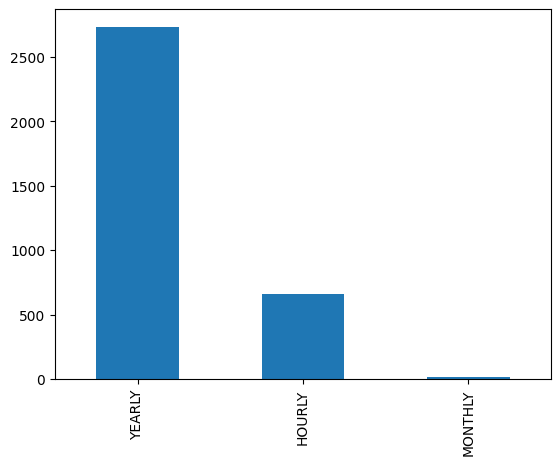

In [112]:
%matplotlib inline
import matplotlib.pyplot as plt

jobs_data['pay_period'].value_counts().plot(kind='bar')